Notebook 3, Module 1, Data and Data Management, CAS Applied Data Science, 2020-08-21, S. Haug, University of Bern. 

# 3. Data acquisition on the world wide web

**Learning outcomes:**

Participants will be able to collect data from www sources. Examples are provided and exercised. We have about 1.5h hours for this tutorial.

**Table of Contents**
- 3.1 Read json from the web
- 3.2 Retrieve and display pictures and files from the web
- 3.3 Scraping webpages (html scraping)
- 3.4 Cron jobs and Scheduled tasks
- Some notes and links concerning social media

**Further sources**
- Examples all over internet
- A book: https://www.packtpub.com/big-data-and-business-intelligence/mastering-social-media-mining-python


## 3.1 Analyse Aare with data from https://aareguru.existenz.ch/



Get the data from website, bring it into a format which can be imported into a dataframe, plot the time series and the histograms.

In [ ]:
from urllib.request import urlopen
import pandas as pd
startlink = "https://aareguru.existenz.ch/v2018/current"
f = urlopen(startlink)
l = str(f.read())
l=l.split('[')[3].split(']')
l='['+l[0]+']'
#print(l)
df = pd.read_json(l)
df.tail()
#df.info()


In [2]:
df.describe()

,flow,temperature
count,288.000000,287.000000
mean,176.961806,22.137143
std,12.709921,0.532211
min,156.000000,21.100000
25%,169.000000,21.820000
50%,183.000000,22.210000
75%,184.000000,22.560000
max,203.000000,22.980000


In [3]:
# We want the timestamp as index for plotting
dft = df.copy()
dft = dft.set_index('timestamp')
dft.tail()
#dft.head()

,flow,temperature
timestamp,,
2023-08-25 10:50:00,201,22.17
2023-08-25 11:00:00,201,22.16
2023-08-25 11:10:00,202,22.15
2023-08-25 11:20:00,202,22.14
2023-08-25 11:30:00,203,22.12


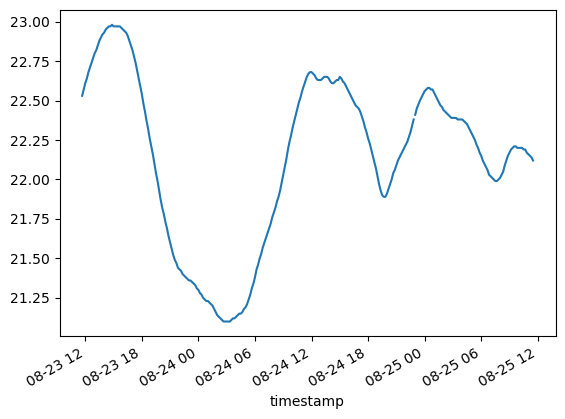

<Axes: xlabel='timestamp'>

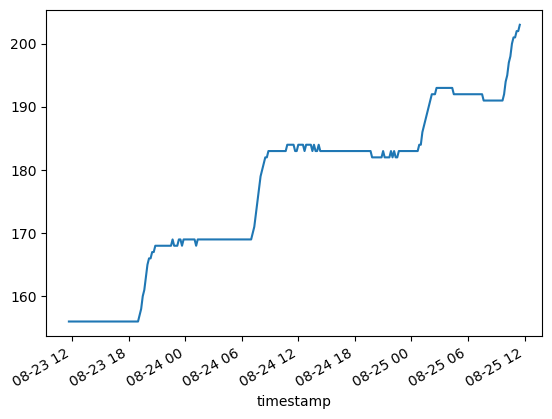

In [4]:
import matplotlib.pyplot as plt
dft['temperature'].plot()
plt.show()
dft['flow'].plot()

In [6]:
Exercise 



NameError: name 'Exercise' is not defined

**Possible further exercise or project for Module 1 and 2**

Find some colleague who can get the historical data (knows how to use the API) out of https://aareguru.existenz.ch/. Bring all data into one data frame. Look for correlations, averages (per month, per year ...). Combine the data with weather data, e.g. the wind on the Thun lake. For the Model 2 project, try to make a linear regression model predicting the Aare temperature. 

## 3.2 Get pictures (or files) from webpages

Get 10 pictures from a webserver with the Image module and show it directly.

In [10]:
from IPython.display import Image as image
from IPython.display import display

for i in range(1,10): 
    url = 'https://fl-5-232.zhdk.cloud.switch.ch/evd.planeview.00001.00000000'+str(i)+'.png'
    img = image(url)
    display(img)

URLError: <urlopen error [Errno 60] Operation timed out>

Download a file into the current directory (for further processing). In this exmple we downloud a file with tweets from the present US president. Then we load it into a dataframe for some analysis.

In [ ]:
import pandas as pd
import urllib
fname="https://fl-5-232.zhdk.cloud.switch.ch/t-tweets.txt"
# retrieve that file and save it as t-tweets.txt
urllib.request.urlretrieve(fname,'t-tweets.txt')
#It has a json format, so we import it with the read_json method
df = pd.read_json('t-tweets.txt')
df.head()


In [ ]:
df.info()

Let's check how often Obama was mentioned in these 245 tweets.

In [ ]:
counter=0
txt = df['text']
for i in range(0,len(txt)):
    if 'Obama' in txt[i]: counter+=1
print(counter)

(Yes, these are prefiltered tweets about Obama)

## 3.3 Scrape Webpages (html scraping)

There are several billion online websites. With python you can easily read and parse this data if you have the links. Since pages are linked, one can in principle unnest probably all internet for webpages. 

In Python there is a library https://www.crummy.com/software/BeautifulSoup/bs4/doc/ for pulling data out of html and xml pages. We don't practise that library here, however, if you at some point deal with a lot of html, you may want to use it.

Here we get the links on the landing page of Science IT Suport, and if there are any, the mail addresses. 
 

In [ ]:
from urllib.request import urlopen
import pandas as pd

#startlink = "http://www.scits.unibe.ch"
startlink = "http://www.scits.unibe.ch/about_us/contact/"
f = urlopen(startlink)
myfile = f.read()
lines = str(myfile).split(' ')
links = []
addresses = []
for line in lines:
    if 'http' in line:
        links.append(line)
    elif '@' in line:
        #print(line)
        addresses.append(line)
df_links = pd.DataFrame(links,columns=['Links'])
df_addrs = pd.DataFrame(addresses,columns=['Adresses'])
df_addrs

The above code is not optimal as you have probably seen. Lets use regular expressions instead (from StackOverflow). Regular expressions are a bit geeky, but very powerful and great fun. If you don't wan't to learn them, you mostly find the expression you want by googling. 

In [9]:
import re # the regular expression module
startlink = "http://www.scits.unibe.ch/about_us/contact/"
f = urlopen(startlink)
html = f.read()
# Extract email addresses
reobj = re.compile(r"\b[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,6}\b", re.IGNORECASE)
print(re.findall(reobj, html.decode('utf-8')))
# Extract urls (links)
urls = re.findall('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', html.decode('utf-8'))
print(urls)

HTTPError: HTTP Error 404: Not Found

### Tables from webpages

If you or someone else pubslishes data in html tables, it can be collected with pandas quite easily, actually directly without using the urllib module.

In [ ]:
import pandas as pd
link = "https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population"
tables = pd.read_html(link)
df = tables[0]
df.head()

In which countries are the people consuming the most energy?

In [ ]:
df.info()

In [ ]:
s_df = df.iloc[1:,1:2] 
s_df['consum'] = df.iloc[1:,7].astype('float')
s_df.sort_values('consum', ascending=False)

In [ ]:
s_df['consum'].plot(kind='hist',bins=50,range=(1000,50000))

## 3.4 Run cron jobs (linux) / scheduled tasks (windows)

If you need to collect data on a regular basis you typically run a so-called cron job on a Linux machine or a scheduled task on a Windows machine. For example, you can specify when and how often your Python data acquisition script should run. Maybe you would like to collect new Aare data every day. Of course, your computer has to be running and connected to internet at the scheduled time.

Here an example collecting Aare data. You can creae a python script aarecollect.py with a text editor. The code can be:

In [ ]:
import urllib
import datetime
link = "https://aareguru.existenz.ch/v2018/current"
filename = 'aare-data-'+ str(datetime.date.today()) +'.json'
urllib.request.urlretrieve(link,filename)



You can run this script from the command line by typing "python aarecollect.py"

On Linux you specify when to execute this file and how often in the so called crontab. On Windows by configuring a Scheduled Task. Google instructions if you need to do this. For example, this file can be added to a users crontab by typing "crontab ~/tmp/mycron.sh" on the command line, mycron.sh being this file:

In [ ]:
>cat ~/tmp/mycron.sh
# Run aarecollect every day at 1am by default
0 1 * * * cd ~/tmp && ./python aarecollect.py


### Possible exercise

Hier a nice little challenge for you. Use the code above (together with a for loop or two) to scrape all webpages of your employer company for public available email addresses and put them into a dataframe :) (of course you could scrape all internet now, but we don't go that far today).

In [ ]:
# Write, copy and paste your code here


## Some notes and links concerning social Media

### 1. Google search

There is are APIs for doing google searches from Python. Hier is one explained. 

https://stackoverflow.com/questions/37083058/programmatically-searching-google-in-python-using-custom-search
 

### 2. Twitter

Twitter generates about 500M tweets per day. Thus, data mining on twitter can be interesting.

Note: there are rate limits in the use of the Twitter API, as well as limitations in case you want to provide a downloadable data-set, see:

https://dev.twitter.com/overview/terms/agreement-and-policy

https://dev.twitter.com/rest/public/rate-limiting

Tweepy is one python module with clients for thwe Twitter API. 

- https://www.tweepy.org/


### 3. Instagram

Largest photo sharing social media platform with 500 million monthly active users, and 95 million pictures and videos uploaded on Instagram daily in 2018 (?). 

https://stackoverflow.com/questions/61010431/how-to-start-with-the-instagramapi-in-python